In [1]:
! git init .
! git remote add origin https://github.com/VLSF/SDC
! git pull origin main

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 135 (delta 71), reused 101 (delta 40), pack-reused 0
Receiving objects: 100% (135/135), 26.05 KiB | 13.02 MiB/s, done.
Resolving deltas: 100% (71/71), done.
From https://github.com/VLSF/SDC
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [2]:
import jax.numpy as jnp
from jax import random, jit, config, vmap
from jax.lax import dot_general
from functools import partial
config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

# How datasets are generated

To generate dataset user needs to provide

1. Function that defines right-hand side of ODE, its derivative in a form of a dict (look at `misc/equations.py`)
  \begin{equation}
    \frac{d u(t)}{dt} = F(u, t)
  \end{equation}
2. Function that takes `jax.random.PRNGKey` and provides samples from distribution over initial conditions.
3. Integration time $T$, so the problem is solved on $[0, T]$.
4. Number of points used on each interval.
5. Number of subintervals the problem is solved on.
6. Number of SDC iterations applied to each interval.
7. Number of samples to generate
8. Base integrator: `"RK4", "Implicit Euler", "Explicit Euler", "Implicit Euler (jac)"`.

Given all that, for each subinterval the approximate solution is computed. The shape of the return tensor is

`(number of samples, number of subintervals, number of SDC iterations, number of ODE components, number of points for each interval)`

Most of the components are self-explanatory, I would like to add that along the axis `number of SDC iterations` I store

$i=0$. Initial conditions on this interval, i.e., the value $u(t_0)$

$i=1$. Solution obtained by a base integrator SDC$(0)$

$i=2$. Soluttion corrected by a single interation of SDC, i.e., SDC$(1)$

$\dots$

# Why datasets are generated

The plan is to test several neural integrators working as predictors, as correctors in between predictor and corrector. Because of that I need all these features.

Targets for prediction ("exact solution") can be extracted from the last SDC iteration.

In [3]:
from datasets import generate_dataset
from misc import equations

# Example: Lorenz system

## RK4

In [4]:
ODE_data = equations.get_ODE("Lorenz")
integrator = "RK4"
P_u0 = lambda key: random.normal(key, (3,))
key = random.PRNGKey(13)
N_points = 40
T_max = 100
N_intervals = 200
N_SDC = 20
N_samples = 10

# dataset on Chebyshev grid
dataset, T = generate_dataset.concoct_regular_dataset(ODE_data, integrator, P_u0, T_max, N_points, N_intervals, N_SDC, N_samples, key)
print("shapes for dataset", dataset.shape, T.shape)

# dataset interpolated on the uniform grid
dataset_u, T_u = generate_dataset.to_uniform_grid(dataset, T)
print("shapes for dataset on the uniform grid", dataset_u.shape, T_u.shape)

# remove redundant values and glue dataset along rime axis
dataset_glued, T_glued = generate_dataset.glue_trajectory(dataset, T)
print("shapes for glued dataset", dataset_glued.shape, T_glued.shape)

shapes for dataset (10, 200, 20, 3, 40) (200, 40)
shapes for dataset on the uniform grid (10, 200, 20, 3, 40) (200, 40)
shapes for glued dataset (10, 20, 3, 7801) (7801,)


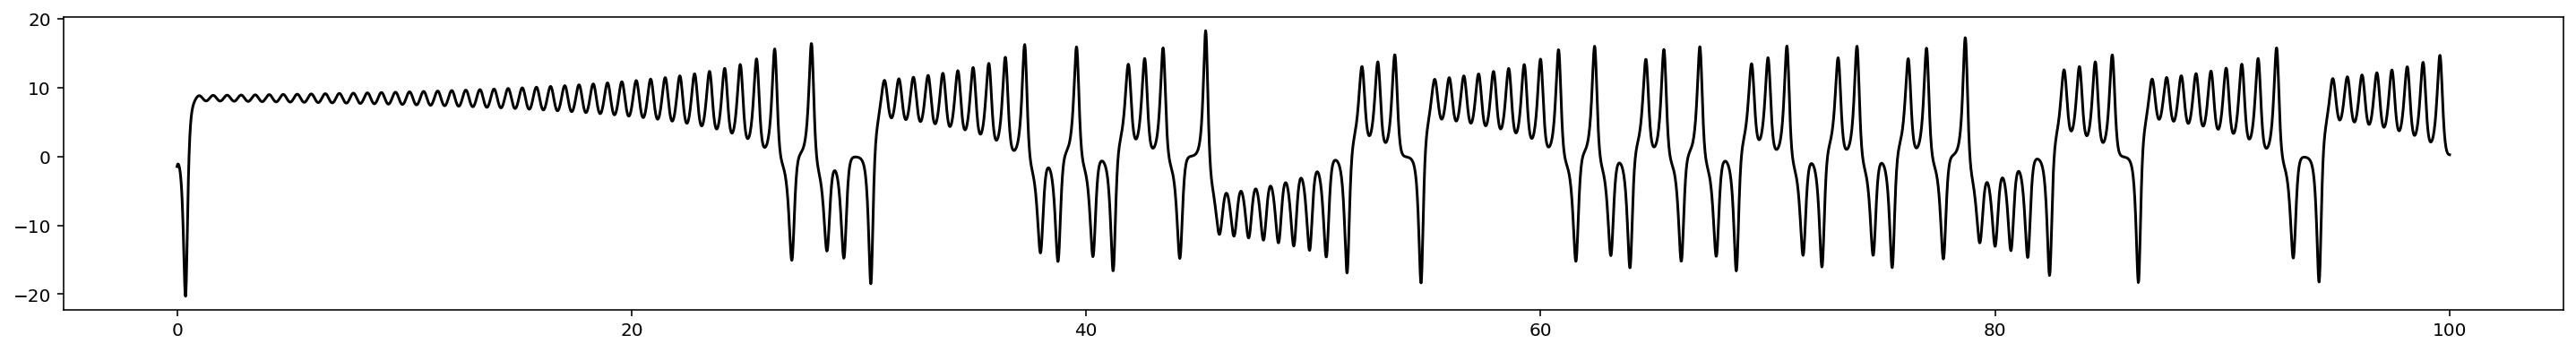

In [5]:
fig, ax = plt.subplots(figsize=(25, 3))
plt.plot(T_glued, dataset_glued[0, -1, 0, :], color="black");

In [6]:
# computing residual for the last SDC iteration
R = generate_dataset.get_residual(dataset, ODE_data, T_max, N_intervals)
print("shape of computed residual", R.shape)
print(jnp.mean(R))

shape of computed residual (10, 200)
3.919968526739276e-14


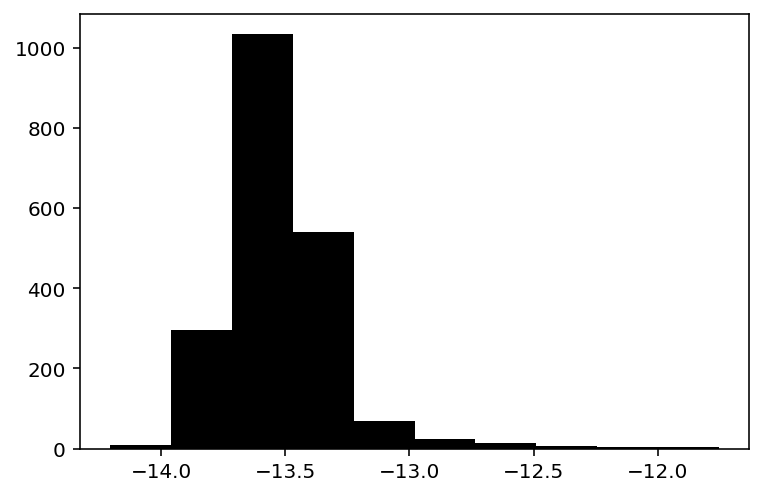

In [7]:
plt.hist(jnp.log10(jnp.ravel(R)), color="black");

## Euler

### Explicit

In [8]:
ODE_data = equations.get_ODE("Lorenz")
integrator = "Explicit Euler"
P_u0 = lambda key: random.normal(key, (3,))
key = random.PRNGKey(13)
N_points = 40
T_max = 100
N_intervals = 200
N_SDC = 20
N_samples = 10

# dataset on Chebyshev grid
dataset, T = generate_dataset.concoct_regular_dataset(ODE_data, integrator, P_u0, T_max, N_points, N_intervals, N_SDC, N_samples, key)
R = generate_dataset.get_residual(dataset, ODE_data, T_max, N_intervals)
print(jnp.mean(R))

1.701603347978273e-09


In [9]:
ODE_data = equations.get_ODE("Lorenz")
integrator = "Explicit Euler"
P_u0 = lambda key: random.normal(key, (3,))
key = random.PRNGKey(13)
N_points = 40
T_max = 100
N_intervals = 400
N_SDC = 20
N_samples = 10

# dataset on Chebyshev grid
dataset, T = generate_dataset.concoct_regular_dataset(ODE_data, integrator, P_u0, T_max, N_points, N_intervals, N_SDC, N_samples, key)
R = generate_dataset.get_residual(dataset, ODE_data, T_max, N_intervals)
print(jnp.mean(R))

2.190254557472286e-14


### Implicit

In [10]:
ODE_data = equations.get_ODE("Lorenz")
integrator = "Implicit Euler"
P_u0 = lambda key: random.normal(key, (3,))
key = random.PRNGKey(13)
N_points = 40
T_max = 100
N_intervals = 200
N_SDC = 20
N_samples = 10

# dataset on Chebyshev grid
dataset, T = generate_dataset.concoct_regular_dataset(ODE_data, integrator, P_u0, T_max, N_points, N_intervals, N_SDC, N_samples, key)
R = generate_dataset.get_residual(dataset, ODE_data, T_max, N_intervals)
print(jnp.mean(R))

3.5765048597612034e-11


### Implicit (jac)

In [11]:
ODE_data = equations.get_ODE("Lorenz")
integrator = "Implicit Euler (jac)"
P_u0 = lambda key: random.normal(key, (3,))
key = random.PRNGKey(13)
N_points = 40
T_max = 100
N_intervals = 200
N_SDC = 20
N_samples = 10

# dataset on Chebyshev grid
dataset, T = generate_dataset.concoct_regular_dataset(ODE_data, integrator, P_u0, T_max, N_points, N_intervals, N_SDC, N_samples, key)
R = generate_dataset.get_residual(dataset, ODE_data, T_max, N_intervals)
print(jnp.mean(R))

3.922657700483252e-11
